# Clustering Overlapping Moons

In [1]:
import numpy as np
import sklearn.mixture
import scipy
from sklearn.preprocessing import KernelCenterer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import code to generate data and do clustNP
from sample_distributions import pair_sample_mixture_of_GMs, sample_intersecting_moons
from clustNP import clustNP, gauss_kernal_mat, gen_ZG, gen_C, clustNP_obj, proj_simplex
from clustering_methods import MVLVM

# Set Parameters

In [2]:
np.random.seed(0) #reproducibility

n = 200 # number of total paired samples
nhold = 200
ntest = 200
R = 20  # number of bins in our discritezation
#R = n
M = 2   # true number of mixture components for our KDE
Mprime = 3 # number of subcomponents
d = 2   # ambient dimension 
w_outer = np.ones((M,)) # true KDE mixture proportions
w_outer *= 1/np.sum(w_outer)
w_outer

array([0.5, 0.5])

# Generate Moon Data

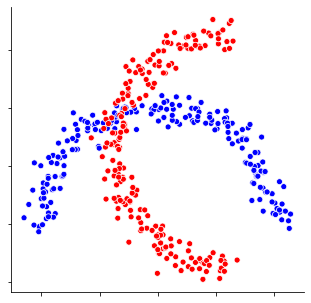

In [3]:
noise_sd = 0.07
X, component_ids, pair_ids = sample_intersecting_moons(n, noise_sd=noise_sd, rot_rad = np.pi/2, rand_state=0)
Xh, cid_h, pid_h = sample_intersecting_moons(nhold, noise_sd=noise_sd, rot_rad = np.pi/2, rand_state=111)
Xte, cid_te, pid_te = sample_intersecting_moons(ntest, noise_sd=noise_sd, rot_rad = np.pi/2, rand_state=99)
#plot the data and look at moons

dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": component_ids[:,], "true_class": pair_ids[:,]})
dfh = pd.DataFrame({"x": Xh[:,0], "y": Xh[:,1], "decisions": cid_h[:,], "true_class": cid_h[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=["b", "r"], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('true_overlapping_moons.eps', format="eps")
# plt.savefig('true_overlapping_moons.png', dpi=300)

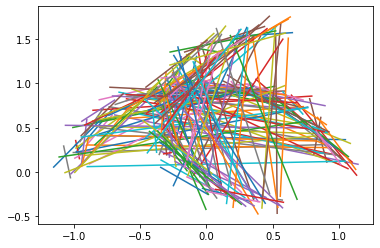

In [4]:
for i in range(n):
    pair = X[pair_ids==i]
    plt.plot(pair[:,0], pair[:,1])

# solve

### Original Param Init

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

# do a line search on sigma to find the best eigenvector initialization
Rs = [20,30,40,50]
best_ISE = 1e10;

for R in Rs:
    Z, _ = gen_ZG(X, R, 1)
    d = Z.shape[1]
    sd = np.mean(np.std(X, axis=0))
    sigmas = [sd*(2*n)**(-1/(d+4))]
    #Z = X
    for sigma in sigmas:
        #Generate initialization for current sigma
        _, G = gen_ZG(X, R, sigma, Z=Z)
        C = gen_C(X, pair_ids, Z, R, sigma)
        w, A = scipy.sparse.linalg.eigs(G, k=M)
        w = np.real(w)
        A = np.real(A)
        for i in range(M):
                A[:,i] = proj_simplex(A[:,i])
        w = w/np.sum(w)
        #w = np.ones(M,) / M
        A = A / np.sum(A,axis=0)
        
        f, _ = clustNP_obj(A, w, G, C, n, 0)
        print(sigma, R, f)
        if f < best_ISE:
            best_ISE = f
            best_sigma = sigma
            best_R = R
            best_w = w
            best_Z = Z
            best_C = C
            best_G = G
            best_A = A
print(best_sigma, best_R, best_ISE)       

0.20407972053672502 20 0.02666505237430009
0.20407972053672502 30 0.15287636731968846
0.20407972053672502 40 0.0333167954243094
0.20407972053672502 50 0.03379020337370285
0.20407972053672502 20 0.02666505237430009


### Optimize

In [6]:
sigma = best_sigma
R = best_R
w0 = best_w
#w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A
#A0 = np.random.rand(R,M)
#A0 = A0 / np.sum(A0, axis=0)
ss=1

print(best_ISE)
# #solve
f_star, A_star, w_star, Z, n_iter = clustNP(X, pair_ids, A0, w0, Z, G, stepsize=ss, ss_decr=1, 
                                            epoch_decr = 40, method='psgd', max_iter=300, f_tol=1e-16, 
                                            grad_tol=1e-8, R=R, sigma=sigma, batch_size=64, backtrack=False,
                                            decay=0.01, momentum=0.1)

f_star

0.02666505237430009


0.0003679250042332993


# Plot KDE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

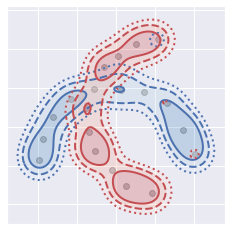

In [7]:
import sklearn.neighbors 

xmin, xmax = -1.4, 1.4
ymin, ymax = -0.75, 2
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-12))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-12))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')


levels = [0.2, 0.3, 0.42, 0.65]
# levels = [0.15, 0.20, 0.30, 0.4]
levels0 = levels
levels1 = levels

CSr = plt.contourf(xx, yy, f0, levels0, cmap="Blues", alpha=sigma)
#plt.contour(CSr, levels=CSr.levels, colors=['r', 'm', ], origin='lower')
CSr2 = plt.contour(xx, yy, f0, levels0,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
# plt.clabel(CSr2, fmt='%2.1f', colors='r', fontsize=10)
#plt.colorbar(CSr)
CSb = plt.contourf(xx, yy, f1, levels1, cmap="Reds", alpha=sigma)

#plt.contour(CSb, levels=CSb.levels, colors='b', origin='lower')
CSb2 = plt.contour(xx, yy, f1, levels1,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
# plt.clabel(CSb2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSb)

# lines = CSr2.collections[:-1]
# plt.legend(lines, levels[:-1], loc='lower left')


plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axis('square')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
plt.savefig('moons_kde_orig_init.eps', format="eps")
plt.savefig('moons_kde_orig_init.png', dpi=300)

# Predict

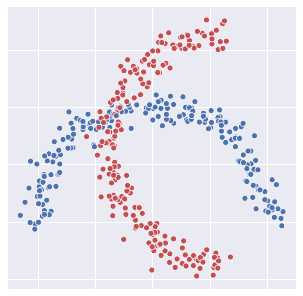

In [8]:
#make predictions
phats_train = np.zeros((X.shape[0], M))
phats_te = np.zeros((Xte.shape[0], M))
for i in range(X.shape[0]):
    kx = gauss_kernal_mat(X[i, np.newaxis], Z, sigma)
    phats_train[i, :] = kx@A_star
for i in range(Xh.shape[0]):
    kxte = gauss_kernal_mat(Xte[i,np.newaxis], Z, sigma)
    phats_te[i, :] = kxte@A_star
ltr = np.zeros((X.shape[0], M))
lte = np.zeros((Xte.shape[0], M))
for i in set(pair_ids):
    ltr[pair_ids==i, :] = np.tile(w_star.T*np.prod(phats_train[pair_ids==i,np.newaxis], axis=0), (2,1))
lte = w_star.T*phats_te
decisions_train = np.argmax(ltr, 1)
decisions_te = np.argmax(lte, 1)


dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": decisions_train[:,], "true_class": component_ids[:,]},)
dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=["b", "r"], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('moons_orig_init.png', dpi=300)
# df_nmf = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": nmf_labels, "true_class": component_ids})
# # #plot data and decisions
# sns.relplot(x ="x", y="y", data=df_nmf, hue="decisions")

In [9]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, decisions_train, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.995

In [10]:
sklearn.metrics.adjusted_rand_score(component_ids, decisions_train)

0.9800500050125616

# MV-LVM

In [11]:
X1, cid1, pid1 = sample_intersecting_moons(n//3, noise_sd=noise_sd,  rot_rad = np.pi/2,rand_state=0)
X2, cid2, pid2 = sample_intersecting_moons(n//3, noise_sd=noise_sd,  rot_rad = np.pi/2,rand_state=111)
X3, cid3, pid3 = sample_intersecting_moons(n//3, noise_sd=noise_sd,  rot_rad = np.pi/2,rand_state=222)

In [12]:
sd = np.min(np.std(X, axis=0))
sigma = sd*(2*n)**(-1/(d+4))
A, w = MVLVM(X1,X2,X3,k=2,sigma=sigma, reg=0.01*sigma)
Xa = np.vstack((X1,X2))

[]

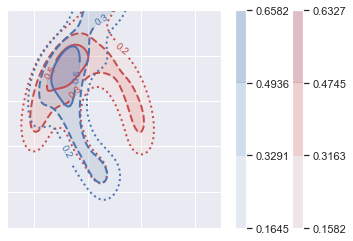

In [13]:
import sklearn.neighbors 

xmin, xmax = -1.5, 2.5
ymin, ymax = -0.9, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde0 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde0.fit(Xa, y=None, sample_weight=(A[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde0.score_samples(positions.T).T, xx.shape))

#class 1
kde1 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde1.fit(Xa, y=None, sample_weight=(A[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde1.score_samples(positions.T).T, xx.shape))

#plot
fig = plt.figure()
ax = fig.gca()
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
#plt.scatter(x=Z[:,0], y=Z[:,1], color='black')
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

num_steps = 4
m0 = np.amax(f0)
m1 = np.amax(f1)
step0 = m0/num_steps
step1 = m1/num_steps
levels0 = np.arange(0.0, m0, step0) + step0

levels1 = np.arange(0.0, m1, step1) + step1
CSr = plt.contourf(xx, yy, f0, levels0, cmap="Reds", alpha=sigma)
#plt.contour(CSr, levels=CSr.levels, colors=['r', 'm', ], origin='lower')
CSr2 = plt.contour(xx, yy, f0, levels0,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '--', '-' ),
                  origin="lower")
plt.clabel(CSr2, fmt='%2.1f', colors='r', fontsize=10)
plt.colorbar(CSr)
CSb = plt.contourf(xx, yy, f1, levels1, cmap="Blues", alpha=sigma)

#plt.contour(CSb, levels=CSb.levels, colors='b', origin='lower')
CSb2 = plt.contour(xx, yy, f1, levels1,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':','--', '-' ),
                  origin="lower")
plt.clabel(CSb2, fmt='%2.1f', colors='b', fontsize=10)
plt.colorbar(CSb)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
# plt.savefig('moons_kde_mvlvm.eps', format="eps")
# plt.savefig('moons_kde_mvlvm.png', dpi=300)

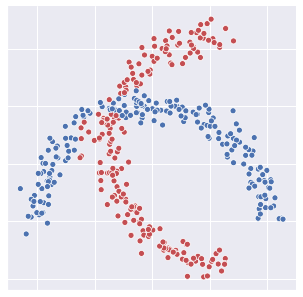

In [14]:
#make predictions
vals_tr = np.zeros((Xa.shape[0] + X3.shape[0],M))
vals_tr[:,0] = kde0.score_samples(np.vstack((Xa,X3)))
vals_tr[:,1] = kde1.score_samples(np.vstack((Xa,X3)))
vals_te = np.zeros((Xte.shape[0],M))
vals_te[:,0] = kde0.score_samples(Xte)
vals_te[:,1] = kde1.score_samples(Xte)
decisions_train = np.argmax(vals_tr, 1)
decisions_te = np.argmax(vals_te, 1)


dftr = pd.DataFrame({"x": np.hstack((Xa[:,0],X3[:,0])), "y": np.hstack((Xa[:,1],X3[:,1])), "decisions": decisions_train[:,], "true_class": np.hstack((cid1,cid2,cid3)).T},)
dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=["b", "r"], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig('moons_mvlvm.png', dpi=300)

In [15]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(cid_te, decisions_te, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.915

In [16]:
sklearn.metrics.adjusted_rand_score(cid_te, decisions_te)

0.6881186551571306

# NPMIX

In [17]:
from NPMIX import NPMIX
labels, ofit_gmm, gmm_assn = NPMIX(X, M=M, M_over=7*M)

0.7375 0.22421658367870245


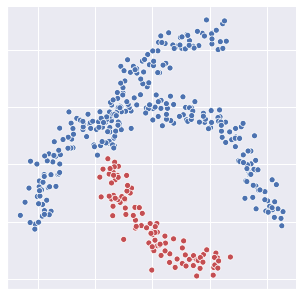

In [18]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['r','b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('intersecting_moons_npmix.eps', format="eps")
# plt.savefig('intersecting_moons_npmix.png', dpi=300)#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)        
print(acc, ARI)



# Constrained GMM for paired samples

In [19]:
from constr_gmm import constr_gmm
    
constr_gmm = constr_gmm(X,pair_ids,M,50,0)     
constr_gmm.run()
labels= np.argmax(constr_gmm.predict(X), axis=1)

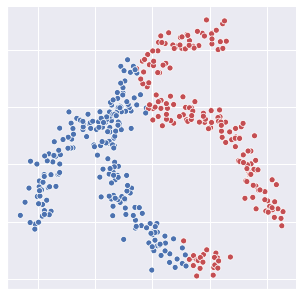

In [20]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b','r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal')
# plt.savefig('moons_constr_gmm.eps', format="eps")
# plt.savefig('moons_constr_gmm.png', dpi=300)

# GMM

In [21]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(X)

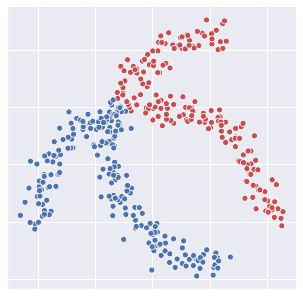

In [22]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b','r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('moons_gmm.eps', format="eps")
# plt.savefig('moons_gmm.png', dpi=300)

In [23]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.595

In [24]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

0.033690037484463045

# Spectral Clustering

In [25]:
import sklearn.cluster
spclust = sklearn.cluster.SpectralClustering(n_clusters=2, gamma=1)
spclust.fit(X)
#d = clust.get_params()

SpectralClustering(gamma=1, n_clusters=2)

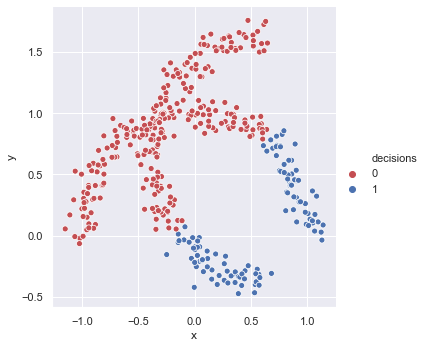

In [26]:
#np.sum(spclust.labels_)
spclust.affinity_matrix_
dfh = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": spclust.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=dfh, hue="decisions", palette=['r','b'])

# Constrained Spectral Clustering

In [27]:
from clustering_methods import constr_spec_clust

connectivity = np.zeros((2*n, 2*n))
for i in range(n):
    i, j = tuple(np.nonzero(pair_ids==i)[0])
    connectivity[i,j] = 1
    connectivity[j,i] = 1
Q = connectivity
A = spclust.affinity_matrix_
beta = 1
u_star, labels, _ = constr_spec_clust(A, Q, beta=beta)

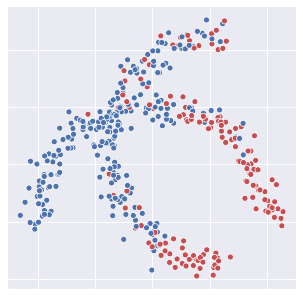

In [28]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels.flatten(), "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['r','b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('moons_constr_spectral.eps', format="eps")
# plt.savefig('moons_constr_spectral.png', dpi=300)

In [29]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, u_star<0, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.52

In [30]:
sklearn.metrics.adjusted_rand_score(component_ids, labels.flatten())

-0.0007637085688101508

# mean shift

In [31]:
clust = sklearn.cluster.MeanShift(bandwidth=0.7)
clust.fit(X)
dfh = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": clust.labels_, "true_class": component_ids})
# tn, fp, fn, tp = confusion_matrix(clust.labels_, component_ids).ravel()
# plot data and decisions

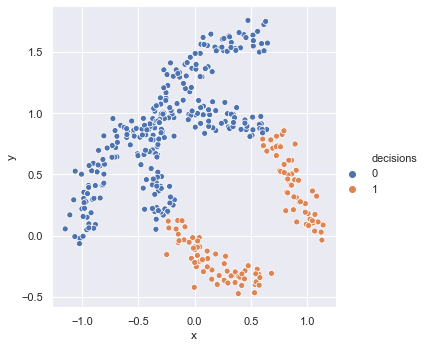

In [32]:
sns.relplot(x ="x", y="y", data=dfh, hue="decisions")
#set(clust.labels_)

# DBSCAN

In [33]:
db = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5, 
                       metric='euclidean', metric_params=None, algorithm='auto', 
                       leaf_size=30, p=None, n_jobs=None)
db.fit(X)
Z = db.components_

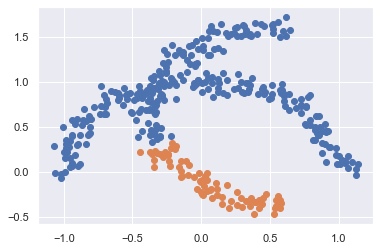

In [34]:
plt.scatter(X[db.labels_==0,0], X[db.labels_==0,1])
plt.scatter(X[db.labels_==1,0], X[db.labels_==1,1])